To note:

- No idea what b is 
- Below is a couple of definitions from the GitHub page which might come in handy

Link travel time = free flow time * ( 1 + B * (flow/capacity)^Power ).
Link generalized cost = Link travel time + toll_factor * toll + distance_factor * distance

# Setup: import packages

In [1]:
#install packages if required
#%pip install networkx

In [2]:
#import packages 
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
from scipy.misc import derivative
import numpy as np
import os
from random import *

In [3]:
network_analysis_path_ben = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Code/Python/working_multiple_eq_flow/pytrans_working_multiple_eq_flow'
#network_analysis_path_niamh = r'C:\Users\35387\OneDrive\Documents\Networks\New folder\Networks_Term_Paper\pytrans_UrbanNetworkAnalysis\pytrans\UrbanNetworkAnalysis\original_edited'
os.chdir(network_analysis_path_ben)
import Frank_Wolfe
import TransportationNetworks as tn
import visualize_graph

In [4]:
#create cities dictionary
def make_dict(cities):
    cities_dict = {}
    for city in cities:
        link_file_path = data_path + city + '/' + city + '_net.tntp.txt'
        node_file_path = data_path + city + '/' + city +'_nodes.tntp.txt'
        trip_file_path = data_path + city + '/' + city + '_trips.tntp.txt'
        cities_dict[city] = {}
        to_add = {'link_file_path': link_file_path, 'node_file_path': node_file_path, 'trip_file_path': trip_file_path}
        cities_dict[city]['file_paths'] = to_add 
    return cities_dict

In [5]:
#create class
#for future iterations - redesign so it takes a city as the class
class fw_custom_algorithm():
    
    def __init__(self, cities_dict):
        self.cities_dict = cities_dict
        self.link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, "B": 6, "beta": 7, "V": 8}
    #create a csv for each city and corresponding file for investigation
 
    #need to fix this to make 
    def create_links_csv(self):
        for city in self.cities_dict.keys():
            path_list = list(self.cities_dict[city]['file_paths'])
            link_file = path_list[0]
            csv = pd.read_csv(self.cities_dict[city]['file_paths'][link_file], skiprows=7, sep='\t') #gets link file path
            trimmed= [s.strip().lower() for s in csv.columns]
            csv.columns = trimmed
            # And drop the silly first andlast columns
            csv.drop(['~', ';'], axis=1, inplace=True)
            cities_dict[city]['csv'] = csv
        self.cities_dict = cities_dict
        
    
    def plot(self, city):
        csv = self.cities_dict[city]['csv']
        try:
            network = nx.from_pandas_edgelist(csv, source = 'init node',target='term node', edge_attr = True)
            graph = nx.complete_graph(network)
            print('Graph for:', city)
            nx.draw(graph)
        except KeyError:
            network = nx.from_pandas_edgelist(csv, source = 'init_node',target='term_node', edge_attr = True)
            graph = nx.complete_graph(network)
            print('Graph for:', city)
            nx.draw(graph)
        
    def summary_stats_all(self):
        for city in self.cities_dict.keys():
            try:
                print('Total number of nodes in', city+':', len(self.cities_dict[city]['csv']['init node'].unique()))
                print('Total number of edges in', city+':', self.cities_dict[city]['csv'].shape[0])
            except KeyError:
                print('Total number of nodes in', city+':', len(self.cities_dict[city]['csv']['init_node'].unique()))
                print('Total number of edges in', city+':', self.cities_dict[city]['csv'].shape[0])
            
    def make_network(self, city, remove_link_number): #remove_link_number can be None or int
        #instatiate class using required files 
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path']
        Network = tn.Network(city, remove_link_number, link_file, trip_file, node_file) 
        self.cities_dict[city][str(remove_link_number)] = {'network': Network}
    
    def make_network_shut_each_link(self, city): 
        #max_edges =  len(self.cities_dict[city]['csv'].shape[0].unique() #get max edges in network for a city
        max_edges = 10 #for a trial 
        #iterate over edges
        for edge in range(0, max_edges+1):
            #instatiate class for network with one file removed using required files 
            link_file = self.cities_dict[city]['file_paths']['link_file_path']
            trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
            node_file = self.cities_dict[city]['file_paths']['node_file_path']
            Network = tn.Network(city, edge, link_file, trip_file, node_file) 
            self.cities_dict[city][str(edge)] = {'network': Network}
            
    def network_attributes(self, city, remove_link_number):
        network = self.cities_dict[city][str(remove_link_number)]['network']
        ##Network has three attributes
        #1) graph object
        graph = network.graph
        #2) origin nodes
        origin_nodes = network.origins
        #3)dict: keys= origin_node, destination_node, value = traffic flow
        flows = network.od_vols
        print(network)
        print(city, 'graph is:', graph)
        print(city, 'origin nodes are:', origin_nodes)
        print(city, 'flows are:', flows)
    
    def compute_link_flow(self, city, remove_link_number):
        network = self.cities_dict[city][str(remove_link_number)]['network']
        SO = False
        fw = Frank_Wolfe.Run(network, SO)
        #saves file to dict
        self.cities_dict[city][str(remove_link_number)]['fw_run'] = fw
        
    def eq_flow_shut_each_link(self, city):
        #max_edges = len(cities_dict[city]['0']['network'].graph.edges)#get max edges in network for a city
        max_edges = 10 #for a trial 
        #iterate over edges
        for edge in range(0, max_edges+1):
            self.compute_link_flow(city, edge)
    
            

            
        



# Set file paths

In [6]:
data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/'
cities = ['friedrichshain-center']
data_path = data_path 
os.chdir(data_path)

# Make dict

In [7]:
cities_dict = make_dict(cities)
cities_dict

{'friedrichshain-center': {'file_paths': {'link_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/friedrichshain-center/friedrichshain-center_net.tntp.txt',
   'node_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/friedrichshain-center/friedrichshain-center_nodes.tntp.txt',
   'trip_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/friedrichshain-center/friedrichshain-center_trips.tntp.txt'}}}

# instantiate class

In [8]:
#instantiate class 
trial_run = fw_custom_algorithm(cities_dict)

# Observe one city

In [9]:
#set city for investigation
city = cities[0]

In [10]:
trial_run.create_links_csv()
cities_dict[city]['csv']

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
0,1,31,999999.0,0.0,0.000000,0.0,4.0,0.0,0.0,0
1,1,32,999999.0,0.0,0.000000,0.0,4.0,0.0,0.0,0
2,1,159,999999.0,0.0,0.000000,0.0,4.0,0.0,0.0,0
3,1,161,999999.0,0.0,0.000000,0.0,4.0,0.0,0.0,0
4,2,31,999999.0,0.0,0.000000,0.0,4.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
518,220,13,999999.0,0.0,0.000000,0.0,4.0,0.0,0.0,0
519,220,68,900.0,112.0,2.666667,1.0,4.0,0.0,0.0,1
520,220,128,900.0,291.0,7.333333,1.0,4.0,0.0,0.0,1
521,221,121,600.0,241.0,6.000000,1.0,4.0,0.0,0.0,1


# Plot graph

Total number of nodes in friedrichshain-center: 218
Total number of edges in friedrichshain-center: 523
Graph for: friedrichshain-center


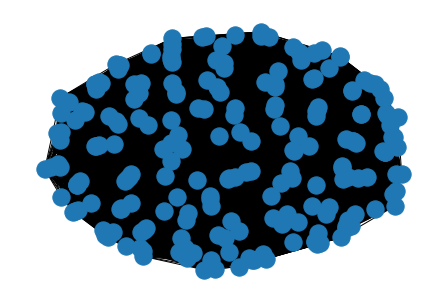

In [11]:
#Create csvs, plot graph and show summary stats
trial_run.summary_stats_all()
trial_run.plot(city)

# Observe example network data

In [12]:
#observe network with all links
remove_link = 0 #0 is equivalent to no links closed
trial_run.make_network(city, remove_link)
trial_run.network_attributes(city, remove_link)

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
#observe network after removing one link
remove_link = 1
trial_run.make_network(city, remove_link)
trial_run.network_attributes(city, remove_link)

# Compute equilibrium flow for example city using Frank-Wolfe algorithm

In [ ]:
#compute the eq flow for one example city and no closed links
remove_link = 0
trial_run.compute_link_flow(city, remove_link)

In [ ]:
#report eq flow for one example city and no closed links
print('Results for:', city)
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlow() #equilibrium flows
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlowMap() #flow map

# Compute equilibrium flow for one closed link in example city using Frank-Wolfe algorithm

In [ ]:
#compute the eq flow for one example city and one closed link
remove_link = 1
trial_run.compute_link_flow(city, remove_link)

In [ ]:
#report eq flow for one example city and one closed links
print('Results for:', city)
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlow() #equilibrium flows
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlowMap() #flow map

# Systematically close each link and compute equilibrium flow for example city

In [ ]:
#need to make the network where each link is shut first
trial_run.make_network_shut_each_link(city)

In [ ]:
#view a network with edge removed
removed_link = 8
trial_run.make_network(city, removed_link)
trial_run.network_attributes(city, removed_link)

In [ ]:
trial_run.eq_flow_shut_each_link(city)

In [ ]:
#report eq flow for one example city and one randomly closed link (flex removed_link, but can't choose more than max edges)
max_edges = len(cities_dict[city]['0']['network'].graph.edges)
print(max_edges)
removed_link = 4
print('Equilibrium flow for removed link number',removed_link, 'in', city)
print('Results for:', city)
trial_run.cities_dict[city][str(removed_link)]['fw_run'].showODFlow() #equilibrium flows
trial_run.cities_dict[city][str(removed_link)]['fw_run'].showODFlowMap() #flow map

In [ ]:
cities_dict